In [1]:
#   ____                            _____     _____                   __          __        _        _                 
#  / __ \                     /\   |_   _|   / ____|                  \ \        / /       | |      | |                
# | |  | |_ __   ___ _ __    /  \    | |    | |  __ _   _ _ __ ___     \ \  /\  / /__  _ __| | _____| |__   ___  _ __  
# | |  | | '_ \ / _ \ '_ \  / /\ \   | |    | | |_ | | | | '_ ` _ \     \ \/  \/ / _ \| '__| |/ / __| '_ \ / _ \| '_ \ 
# | |__| | |_) |  __/ | | |/ ____ \ _| |_   | |__| | |_| | | | | | |     \  /\  / (_) | |  |   <\__ \ | | | (_) | |_) |
#  \____/| .__/ \___|_| |_/_/    \_\_____|   \_____|\__, |_| |_| |_|      \/  \/ \___/|_|  |_|\_\___/_| |_|\___/| .__/ 
#        | |                                         __/ |                                                      | |    
#        |_|                                        |___/                                                       |_|    

In [2]:
!pip install gym
#!pip install torch==1.5.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

In [3]:
from itertools import count

from typing import Dict, List, Optional, Callable

import torch
from torch import Tensor

import random
from random import randint

In [4]:
class TxWirelessModel:
  def __init__(self, n_freqs: int, horizon: int):
    self.hor = horizon  # model horizon
    self.tx_freq: Tensor = torch.randint(n_freqs, size=(horizon, ))  # random Tx frequencies w.r.t. time-step

  def rx_reward(self, t: int, freq: int):
    if t >= self.hor:  # horizon reached, always return 0
      return 0.0
    return float(self.tx_freq[t] == freq)  # float(True) = 1.0 if Tx and Rx frequencies are the same

In [5]:
class RxQLearning1:
  def __init__(self, n_actions: int, lr: float, gamma: float):
    self.qtable: Dict[int, Tensor] = dict()  # Q-table with time-step as keys for a 1D Q-table of n_freqs
    self.n_actions = n_actions  # number of actions
    self.lr = lr  # learning rate
    self.gamma = gamma  # gamma parameter

  def value(self, o: int, a: int) -> float:  # Q-value e.i. Q(o, a)
    if o not in self.qtable:
      self.qtable[o] = torch.zeros(self.n_actions)  # add new Q-table, Q-values are zero

    return self.qtable[o][a].item()  # return Q-value

  def update(self, o, a, r, o_prime) -> float:  # Q-learning update
    if o not in self.qtable:
      self.qtable[o] = torch.zeros(self.n_actions)  # add new Q-table for new obs, Q-values are zero

    if o_prime not in self.qtable:
      self.qtable[o_prime] = torch.zeros(self.n_actions)  # add new Q-table for new obs, Q-values are zero

    old_o_a_value = self.qtable[o][a].item()  # keep old Q-values to compute delta update

    td_target = r + self.gamma * self.qtable[o_prime].max().item()  # compute Temporal-Difference target (e.i [r + gamma * Q(o', a_max)])
    self.qtable[o][a] += self.lr * (td_target - self.qtable[o][a].item())  # update Q-table (e.i. Q(o, s) <- Q(o, s) + lr * [TD-target - Q(o, a)])

    return self.qtable[o][a].item() - old_o_a_value  # return delta update to training loop

In [6]:
random.seed(1234)  # python random number generator seed
torch.manual_seed(1234)  # pytorch random number generator seed

n_freqs = 4  # number of frequencies
horizon = 3  # horizon of our episodes
model = TxWirelessModel(n_freqs, horizon)  # our model

lr = 0.15  # learning rate
gamma = 0.0  # gamma parameter
agent = RxQLearning1(n_actions=n_freqs, lr=lr, gamma=gamma)  # our agent

show_verbose = False  # print information for debugging

# print training parameters
print(
  'model: {{n_freqs={n_freqs}, horizon={horizon}}}, '
  'agent: {{lr={lr}, gamma={gamma}}}'.format(
    n_freqs=n_freqs, horizon=horizon, lr=lr, gamma=gamma
  )
)

for episode_i in count():  # training loop
  delta_update: List[float] = []  # delta update of our Q-table
  n_successes: int = 0  # number of optimal actions (actions with maximum reward)
  cumul_r: float = 0.0  # cumulative reward
  o: Optional[int] = None  # observation (e.i. complete or incomplete state)
  a: Optional[int] = None  # action
  r: Optional[float] = None  # reward

  if show_verbose:
    print('starting episode {episode_i}...'.format(episode_i=episode_i))

  for t in range(horizon + 1):  # horizon + 1 (include terminal transition)
    
    if o is not None and a is not None and r is not None:  # e.g. t >= 1
      delta_update.append(agent.update(o, a, r, o_prime=t))
      if show_verbose:  # print transition of our model (e.i. <o, a, r, o'>)
        print(
          'transition=<{o}, {a}, {r}, {o_prime}>,'
          ' delta_update={delta}'.format(
            o=o, a=a, r=r, o_prime=t, delta=delta_update[-1]
          )
        )

    if t < horizon:  # non-terminal state
      o = t  # time-step is our only observation
      a = randint(0, n_freqs - 1)  # always choose random actions
      a_v = agent.value(o, a)  # random action value
      r = model.rx_reward(t=o, freq=a)  # interact with environment
      cumul_r += r  # add reward to cumulative reward
      n_successes += 1 if r > 0.0 else 0  # success if optimal action-reward

  # show episode results
  print(
    'episode {episode_i}: cumul_reward={cumul_r}, accuracy:{acc:0.5}, '
    'cumul_delta={cumul_delta:0.5}'.format(
      episode_i=episode_i, cumul_r=cumul_r, acc=n_successes / horizon,
      cumul_delta=sum(delta_update)
    )
  )

  if episode_i >= 50:  # exit training after 50 episode
    break

model: {n_freqs=2, horizon=3}, agent: {lr=0.15, gamma=0.0}
episode 0: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.3
episode 1: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.1275
episode 2: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.25837
episode 3: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.092119
episode 4: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.255
episode 5: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.078301
episode 6: cumul_reward=0.0, accuracy:0.0, cumul_delta=0.0
episode 7: cumul_reward=0.0, accuracy:0.0, cumul_delta=0.0
episode 8: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.066556
episode 9: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.10837
episode 10: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.20049
episode 11: cumul_reward=0.0, accuracy:0.0, cumul_delta=0.0
episode 12: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.056572
episode 13: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.078301
episode 14: cumul_reward=

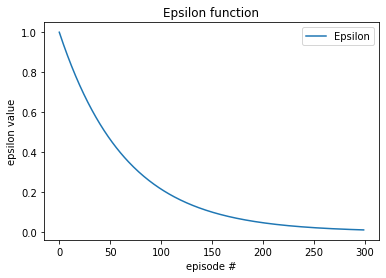

In [7]:
import matplotlib.pyplot as plt

def build_epsilon_fn(steps: int) -> Callable[[int], float]:  # epsilon function builder
  log_epsilon_space = torch.logspace(1.0, -1.0, steps=steps, base=10.0) / 10.0  # epsilon log-space {1.0, ..., 0.0}

  def epsilon_fn(episode_i: int):  # epsilon function
    if episode_i >= steps:  # max step reached
      return 0.0  
    return log_epsilon_space[episode_i].item()  # return epsilon value

  return epsilon_fn  # return our function as an callable object

def epsilon_fn2(episode_i: int, steps: int):  # epsilon function
  log_epsilon_space = torch.logspace(1.0, -1.0, steps=steps, base=10.0) / 10.0  # epsilon log-space {1.0, ..., 0.0}
  if episode_i >= steps:  # max step reached
    return 0.0  
  return log_epsilon_space[episode_i].item()  # return epsilon value

# display the curve for workshop purpose
n_eps_fn_steps = n_episodes = 300
episode_i = 2
epsilon_fn2(episode_i, n_eps_fn_steps)

epsilon_fn = build_epsilon_fn(n_eps_fn_steps)
plot_x = [i for i in range(n_episodes)]
plot_y = [epsilon_fn(x) for x in plot_x]
plt.plot(plot_x, plot_y, label="Epsilon")

plt.xlabel("episode #")
plt.ylabel("epsilon value")
plt.title("Epsilon function")
plt.legend()
plt.show()

In [8]:
class RxQLearning2:
  def __init__(self, n_actions: int, lr: float, gamma: float):
    self.qtable: Dict[int, Tensor] = dict()  # Q-table with time-step as keys for a 1D Q-table
    self.n_actions = n_actions  # number of actions
    self.lr = lr  # learning rate
    self.gamma = gamma  # gamma parameter

  def value(self, o: int, a: int) -> float:  # Q-value e.i. Q(o, a)
    if o not in self.qtable:
      self.qtable[o] = torch.zeros(self.n_actions)  # add new Q-table for new obs, Q-values are zero

    return self.qtable[o][a].item()  # return Q-value

  def update(self, o, a, r, o_prime) -> float:  # Q-learning update
    if o not in self.qtable:
      self.qtable[o] = torch.zeros(self.n_actions)  # add new Q-table for new obs, Q-values are zero

    if o_prime not in self.qtable:
      self.qtable[o_prime] = torch.zeros(self.n_actions)  # add new Q-table for new obs, Q-values are zero

    old_o_a_value = self.qtable[o][a].item()  # keep old Q-values to compute delta update

    td_target = r + self.gamma * self.qtable[o_prime].max().item()  # compute Temporal-Difference target (e.i [r + gamma * Q(o', a_max)])
    self.qtable[o][a] += self.lr * (td_target - self.qtable[o][a].item())  # update Q-table (e.i. Q(o, s) <- Q(o, s) + lr * [TD-target - Q(o, a)])

    return self.qtable[o][a].item() - old_o_a_value  # return delta update to training loop

  def policy(self, o: int, eps: float) -> int:  # policy pi(o)
    if random.uniform(1.0, 0.0) < eps:  # epsilon-greedy condition for exploration
      return randint(0, self.n_actions - 1)  # exploring random action

    return self.qtable[o].argmax().item()  # return frequency with highest Q-value

In [9]:
random.seed(1234)  # python random number generator seed
torch.manual_seed(1234)  # pytorch random number generator seed

n_freqs = 4  # number of frequencies
horizon = 15  # horizon of our episodes
model = TxWirelessModel(n_freqs, horizon)  # our model

lr = 0.15  # learning rate
gamma = 0.0  # gamma parameter
eps_fn_steps = 200  # number of steps (episodes) in epsilon log-space
eps_fn = build_epsilon_fn(eps_fn_steps)  # build our epsilon function

agent = RxQLearning2(n_actions=n_freqs, lr=lr, gamma=gamma)  # our Rx agent

show_verbose = False  # print information for debugging

# print simulation parameters
print(
  'model: {{n_freqs={n_freqs}, horizon={horizon}}}, '
  'agent: {{lr={lr}, gamma={gamma}, eps_fn_steps={eps_fn_steps}}}'.format(
    n_freqs=n_freqs, horizon=horizon, lr=lr, gamma=gamma,
    eps_fn_steps=eps_fn_steps
  )
)

for episode_i in count():  # training loop
  delta_update: List[float] = []  # delta update of our Q-table
  n_successes: int = 0  # number of optimal actions (actions with maximum reward)
  cumul_r: float = 0.0  # cumulative reward
  o: Optional[int] = None  # observation (e.i. complete or incomplete state)
  a: Optional[int] = None  # action
  r: Optional[float] = None  # reward
  eps = eps_fn(episode_i)  # epsilon w.r.t episode number

  if show_verbose:
    print(
      'starting episode {episode_i}'.format(episode_i=episode_i)
    )

  for t in range(horizon + 1):  # horizon + 1 (include terminal transition)
      
    if o is not None and a is not None and r is not None:  # e.g. t >= 1
      delta_update.append(agent.update(o, a, r, o_prime=t))  # update agent with transition, get delta update
      if show_verbose:  # show transition of our model (e.i. <o, a, r, o'>)
        print(
          'transition=<{o}, {a}, {r}, {o_prime}>,'
          ' delta_update={delta}'.format(
            o=o, a=a, r=r, o_prime=t, delta=delta_update[-1]
          )
        )

    if t < horizon:  # non-terminal state
      o = t  # time-step as our only observation
      a = agent.policy(o, eps)  # choose frequency action
      r = model.rx_reward(t=o, freq=a)  # interact with model
      cumul_r += r  # add reward to cumulative reward
      n_successes += 1 if r > 0.0 else 0  # success if optimal action-reward

  # show episode results
  print(
    'episode {episode_i}: cumul_reward={cumul_r}, accuracy:{acc:0.5}, '
    'cumul_delta={cumul_delta:0.5}, eps={eps:0.5}'.format(
      episode_i=episode_i, cumul_r=cumul_r, acc=n_successes / horizon,
      cumul_delta=sum(delta_update), eps=eps
    )
  )

  if episode_i > eps_fn_steps:  # exit training when epsilon reaches 0
    break


model: {n_freqs=2, horizon=3}, agent: {lr=0.15, gamma=0.0, eps_fn_steps=200}
episode 0: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.3, eps=1.0
episode 1: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.2775, eps=0.97712
episode 2: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.23587, eps=0.95477
episode 3: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.20049, eps=0.93293
episode 4: cumul_reward=3.0, accuracy:1.0, cumul_delta=0.29792, eps=0.91159
episode 5: cumul_reward=0.0, accuracy:0.0, cumul_delta=0.0, eps=0.89074
episode 6: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.17493, eps=0.87036
episode 7: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.13487, eps=0.85045
episode 8: cumul_reward=3.0, accuracy:1.0, cumul_delta=0.20676, eps=0.83099
episode 9: cumul_reward=1.0, accuracy:0.33333, cumul_delta=0.040874, eps=0.81198
episode 10: cumul_reward=0.0, accuracy:0.0, cumul_delta=0.0, eps=0.79341
episode 11: cumul_reward=2.0, accuracy:0.66667, cumul_delta=0.11304, eps=0